In [1]:
# My projects were hosted internally - so I don't have relevant projects
# I put this together - but am also more than willing to undergo a test project
# I'll take the Day of Year vs. Parameter files, clean and format
# them into the provided Donation Data versus Day file

In [32]:
from requests import get
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('fivethirtyeight')

In [3]:
# Crawl the fundrasing data page, and extract the csv files from the html table

wmf_url = 'https://frdata.wikimedia.org/'
html_data = BeautifulSoup(get(wmf_url).text, 'html.parser')
urls = html_data.table.find_all('a')

In [4]:
# Read each file into a pandas dataframe and store them as a list

date_format=lambda d: pd.to_datetime(d).strftime('%m-%d-')

dfs = [pd.read_csv(wmf_url + i.text, 
                   parse_dates=['date'],
                   date_parser=date_format) 
       for i in urls]

In [5]:
# In viewing the the data, leap year is accounted for each column.
# This prevents us from performing any time series analysis
# Before I take care of this, I will first to pivot the data

dfs[0].loc[59:59]

,date,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
59,02-29-,NaN,NaN,NaN,NaN,NaN,27.256933,NaN,NaN,NaN,9.496109,NaN,NaN,NaN


In [6]:
# Pivot the dataframe so that its columns are ['date', 'year', 'value'] using pandas melt method

col_names = [i.text.split(sep='-')[-1][:-4] for i in urls]

melted_dfs = [pd.melt(df, id_vars='date', var_name='year', 
                      value_name=col_names[i]) for i, df in enumerate(dfs, 0)]

In [7]:
# We could drop nulls, and leap year would be taken care of
# but then there wouldnt be much to show here
# instead I will calculate which year should be a leap year
# and remove non leap year dates before converting to datetime

# set year col to int and take modulo 4 to identify leap years
for df in melted_dfs:
    df['year'] = df.year.astype('int')
    df['leap_year'] = df.year % 4
    idx = df.query('date == "02-29-" & leap_year != 0').index.to_list()
    df.drop(idx, inplace=True)
    df['date'] = pd.to_datetime(df.date + df.year.astype(str))
    df.drop('leap_year', 1, inplace=True)
    df.drop('year', 1, inplace=True)
    

In [8]:
dfs = [df.set_index('date') for df in melted_dfs]

In [9]:
df = pd.concat(dfs, axis=1)

In [10]:
df.reset_index(inplace=True)

In [11]:
df['avg'] = np.round(df['avg'], 2)

In [12]:
df['year'] = pd.to_datetime(df.date).dt.strftime('%Y')
df['month'] = pd.to_datetime(df.date).dt.strftime('%m')
df['day'] = df.date.dt.day_name()

<h2>Data Dictionary</h2>

<table>
    <tr>
        <th>date</th>
        <th>avg</th>
        <th>max</th>
        <th>donations</th>
        <th>sum</th>
        <th>ytdsum</th>
        <th>refund_sum</th>
        <th>refunds</th>
        <th>ytdloss</th>
        <th>year</th>
        <th>month</th>
        <th>day</th>
    </tr>
    <tr>
        <th>Composite inform</th>
        <th>Average donation given on day</th>
        <th>Maximum donation given on day</th>
        <th>Total number of donations on day</th>
        <th>Daily total given (not including refunds)</th>
        <th>Year to date sum of donations (not accounting for refunds)</th>
        <th>Daily total lost due to refunds</th>
        <th>Total number of refunds on day</th>
        <th>Year to date sum of loss due to refunds</th>
        <th>Year</th>
        <th>Month of year</th>
        <th>Day of week</th>
    </tr>
</table>

In [13]:
# When I store data in a data store meant for analysis, 
# I like to incldue supplementary values that easily 
# allow users to perform their aggretations.
# As far as pandas goes, there is also a slight performance gain.

df.iloc[800:805]

,date,avg,max,donations,sum,ytdsum,refund_sum,refunds,ytdloss,year,month,day
800,2009-03-11,31.44,200.00,21.0,660.22,515646.71,0.0,0.0,0.0,2009,03,Wednesday
801,2009-03-12,48.35,127.82,20.0,967.08,516613.79,0.0,0.0,0.0,2009,03,Thursday
802,2009-03-13,31.79,100.00,17.0,540.43,517154.22,0.0,0.0,0.0,2009,03,Friday
803,2009-03-14,28.02,100.00,17.0,476.36,517630.58,0.0,0.0,0.0,2009,03,Saturday
804,2009-03-15,42.59,375.00,23.0,979.61,518610.19,0.0,0.0,0.0,2009,03,Sunday


In [14]:
# Performance of grouping by year using a datetime conversion in groupby

%timeit dt_group = df.groupby(df.date.dt.year).mean()

1.72 ms ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
# Performance of grouping by year column

%timeit year_group = df.groupby('year').mean()

1.38 ms ± 8.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
# Year df - ignore 2007, 2008 and 2019
year_df = df.groupby('year').sum()[2:-1]
month_mean = df.groupby('month').mean()
day_mean = df.groupby('day').mean()

In [17]:
# I like to first look at the correlation between the variables

corr = df[['avg', 'max', 'donations', 'sum', 'ytdsum']].corr()

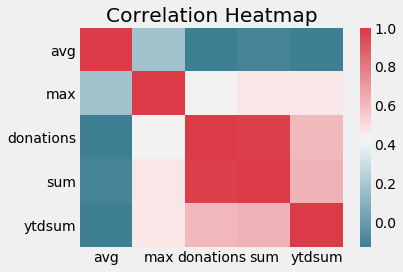

In [33]:
# For me, the most interesting correlation is the strong negative correlation
# between the number of donations, and average donation size.

sns.heatmap(corr, xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title('Correlation Heatmap')
plt.tight_layout();

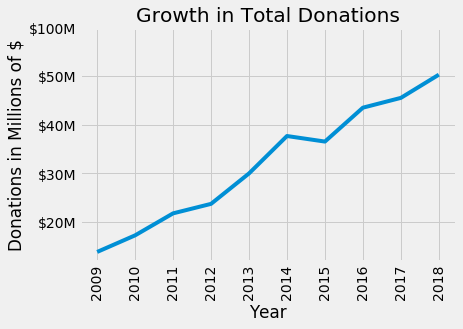

In [34]:
# Let's view the growth in donations by year
# Donation growth seems to be growing in a linear fashion

sns.lineplot(year_df.index, year_df['sum'])

plt.xlabel('Year')
plt.xticks(rotation=90)

plt.ylabel('Donations in Millions of $')
plt.yticks([100000000, 20000000, 40000000, 60000000, 80000000], ['$100M', '$20M', '$30M', '$40M', '$50M'])

plt.title('Growth in Total Donations');

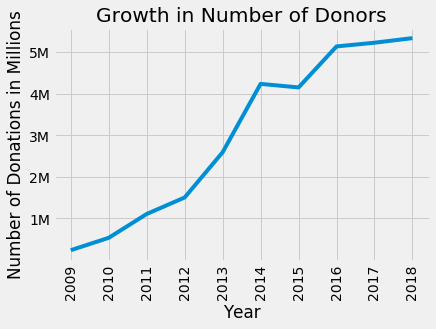

In [35]:
# Let's view the donor growth.  
# Donors appear to have or is begining to reach a plateau.

sns.lineplot(year_df.index, year_df.donations)

plt.xlabel('Year')
plt.xticks(rotation=90)

plt.ylabel('Number of Donations in Millions')
plt.yticks([1000000, 2000000, 3000000, 4000000, 5000000], ['1M', '2M', '3M', '4M', '5M'])

plt.title("Growth in Number of Donors");

In [36]:
avg_donation = df.groupby('year').mean()[2:-1]

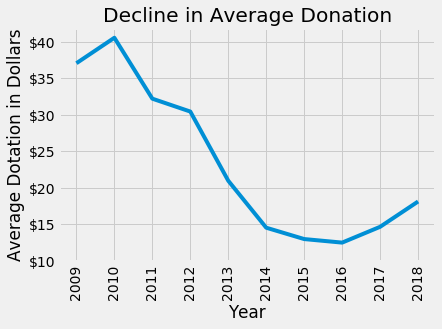

In [37]:
# Let's look at the average donation size
# Over time the average donation decreased, bottoming in 2016 
# Has been increasing since

sns.lineplot(avg_donation.index, avg_donation.avg)

plt.xlabel('Year')
plt.xticks(rotation=90)

plt.ylabel('Average Dotation in Dollars')
plt.yticks([10, 15, 20, 25, 30, 35, 40], ['$10', '$15', '$20', '$25', '$30', '$35', '$40'])

plt.title("Decline in Average Donation");

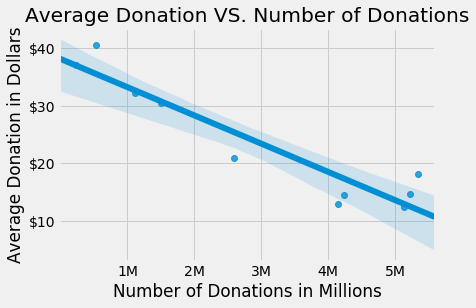

In [47]:
# When we plot a scatter plot of the year and average donation,
# It is visiuble that as number of donations increases, the 
# average donation size decreases.

sns.regplot(year_df.donations, avg_donation['avg'])

plt.xlabel('Number of Donations in Millions')
plt.xticks([1000000, 2000000, 3000000, 4000000, 5000000], ['1M', '2M', '3M', '4M', '5M'])


plt.ylabel('Average Donation in Dollars')
plt.yticks([10, 20, 30, 40], ['$10', '$20', '$30', '$40'])

plt.title("Average Donation VS. Number of Donations");

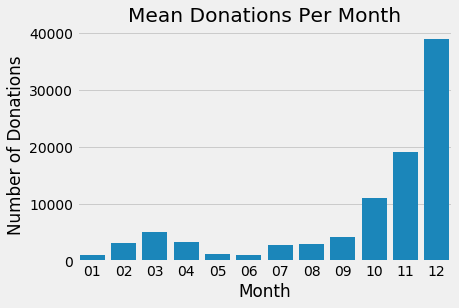

In [39]:
# Let's view the number of donations by month.
# The majority of donations come from Oct, Nov, and Dec

color = sns.color_palette()[0]

sns.barplot(month_mean.index, month_mean.donations, color=color)

plt.xlabel('Month')

plt.ylabel('Number of Donations')

plt.title("Mean Donations Per Month");


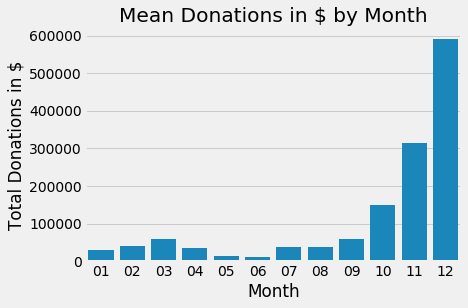

In [40]:
# The mean donation amount appears to follow this pattern

sns.barplot(month_mean.index, month_mean['sum'], color=color)

plt.xlabel('Month')

plt.ylabel('Total Donations in $')

plt.title("Mean Donations in $ by Month");

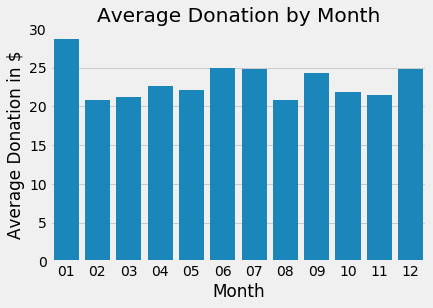

In [41]:
# While the largest average donation appears in Jan

sns.barplot(month_mean.index, month_mean['avg'], color=color)

plt.xlabel('Month')

plt.ylabel('Average Donation in $')

plt.title("Average Donation by Month");


In [42]:
day_mean.reset_index(inplace=True) 

In [43]:
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
week_order = pd.api.types.CategoricalDtype(ordered=True, categories=ordered_days)
day_mean['day'] = day_mean['day'].astype(week_order)

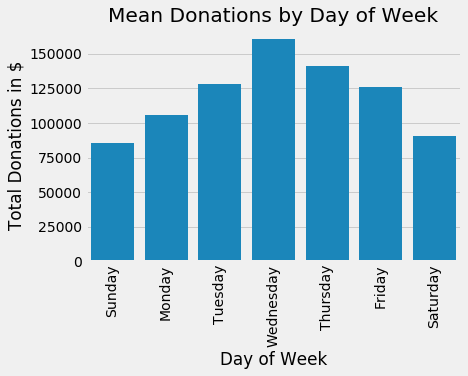

In [44]:
# Historically Wednesday has the highest total donation amount

sns.barplot(day_mean['day'], day_mean['sum'], color=color)

plt.xlabel('Day of Week')
plt.xticks(rotation=90)

plt.ylabel('Total Donations in $')

plt.title("Mean Donations by Day of Week");

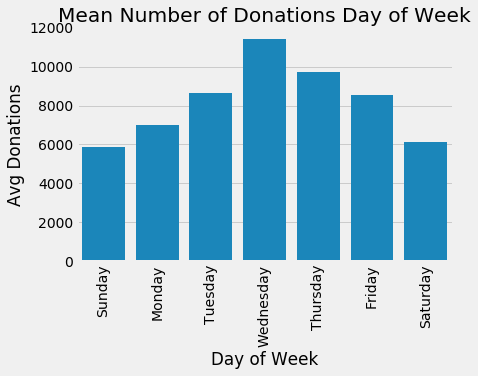

In [45]:
# Historically, Wednesday also has the highest number of donations

sns.barplot(day_mean['day'], day_mean['donations'], color=color)

plt.xlabel('Day of Week')
plt.xticks(rotation=90)

plt.ylabel('Avg Donations')

plt.title("Mean Number of Donations Day of Week");

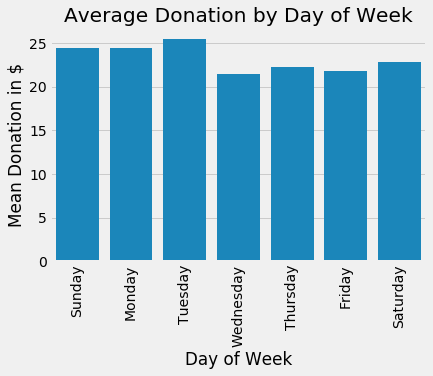

In [46]:
# While Tuesday has the highest average donation

sns.barplot(day_mean['day'], day_mean['avg'], color=color)

plt.xlabel('Day of Week')
plt.xticks(rotation=90)

plt.ylabel('Mean Donation in $')

plt.title("Average Donation by Day of Week");